# Evolver Loop 1 Analysis: Overlap Validation Issue

## Problem
The baseline submission failed with: "Overlapping trees in group 002"

This means Kaggle's validation is stricter than our local validation. We need to:
1. Understand why the overlap wasn't detected locally
2. Implement stricter validation using integer scaling
3. Fix the overlapping trees in the submission

In [1]:
import pandas as pd
import numpy as np
from shapely.geometry import Polygon
from shapely import affinity
from decimal import Decimal, getcontext
import json

getcontext().prec = 30
SCALE = 10**18

# Tree polygon vertices
TX = [0, 0.125, 0.0625, 0.2, 0.1, 0.35, 0.075, 0.075, -0.075, -0.075, -0.35, -0.1, -0.2, -0.0625, -0.125]
TY = [0.8, 0.5, 0.5, 0.25, 0.25, 0, 0, -0.2, -0.2, 0, 0, 0.25, 0.25, 0.5, 0.5]

def get_tree_polygon(x, y, angle):
    """Create a tree polygon at position (x, y) with rotation angle."""
    coords = list(zip(TX, TY))
    poly = Polygon(coords)
    poly = affinity.rotate(poly, angle, origin=(0, 0))
    poly = affinity.translate(poly, x, y)
    return poly

def parse_value(val):
    """Parse a value that may be prefixed with 's'."""
    if isinstance(val, str) and val.startswith('s'):
        return float(val[1:])
    return float(val)

print("Functions defined")

Functions defined


In [2]:
# Load the submission that failed
df = pd.read_csv('/home/submission/submission.csv')
print(f"Loaded {len(df)} rows")
print(df.head(10))

Loaded 20100 rows
      id                        x                       y  \
0  001_0  s-48.196086194214246001  s58.770984615214225000   
1  002_0    s0.154097069621355887  s-0.038540742694794648   
2  002_1   s-0.154097069621372845  s-0.561459257305224058   
3  003_0    s1.123655816140301000   s0.781101815992563000   
4  003_1    s1.234055695842160000   s1.275999500663759000   
5  003_2    s0.641714640229075000   s1.180458566613381000   
6  004_0   s-0.293851410924251905   s0.131832274691205789   
7  004_1    s0.309342302194307898   s0.123870116960718518   
8  004_2    s0.301677672338617802  s-0.724663236194360339   
9  004_3   s-0.301407305808757747  s-0.714797614606864118   

                       deg  
0   s45.000000000000000000  
1  s144.272760863123583164  
2  s324.272760863123533426  
3  s111.125132292892999999  
4   s66.370622269343000001  
5  s155.134051937100820001  
6  s154.766362231348020728  
7  s154.766362354975720805  
8  s334.766362354975635540  
9  s334.766362231348

In [3]:
# Check N=2 specifically - this is where the overlap was detected
n2_rows = df[df['id'].str.startswith('002_')]
print(f"N=2 has {len(n2_rows)} trees")
print(n2_rows)

N=2 has 2 trees
      id                       x                       y  \
1  002_0   s0.154097069621355887  s-0.038540742694794648   
2  002_1  s-0.154097069621372845  s-0.561459257305224058   

                       deg  
1  s144.272760863123583164  
2  s324.272760863123533426  


In [4]:
# Parse N=2 trees
trees_n2 = []
for _, row in n2_rows.iterrows():
    x = parse_value(row['x'])
    y = parse_value(row['y'])
    deg = parse_value(row['deg'])
    trees_n2.append((x, y, deg))
    print(f"Tree: x={x:.15f}, y={y:.15f}, deg={deg:.15f}")

Tree: x=0.154097069621356, y=-0.038540742694795, deg=144.272760863123580
Tree: x=-0.154097069621373, y=-0.561459257305224, deg=324.272760863123551


In [5]:
# Check for overlap using standard Shapely (what we used locally)
poly1 = get_tree_polygon(*trees_n2[0])
poly2 = get_tree_polygon(*trees_n2[1])

print(f"Poly1 bounds: {poly1.bounds}")
print(f"Poly2 bounds: {poly2.bounds}")
print(f"Poly1 area: {poly1.area}")
print(f"Poly2 area: {poly2.area}")
print(f"\nStandard Shapely check:")
print(f"  intersects: {poly1.intersects(poly2)}")
print(f"  touches: {poly1.touches(poly2)}")
print(f"  overlaps: {poly1.overlaps(poly2)}")
print(f"  intersection area: {poly1.intersection(poly2).area}")

Poly1 bounds: (-0.3130447065040463, -0.6879855525119221, 0.4382291739163491, 0.16761500127124365)
Poly2 bounds: (-0.43822917391636595, -0.7676150012712624, 0.3130447065040294, 0.08798555251190321)
Poly1 area: 0.245625
Poly2 area: 0.24562499999999998

Standard Shapely check:
  intersects: True
  touches: False
  overlaps: True
  intersection area: 0.14942653303750386


In [6]:
# Check with high-precision integer scaling (Kaggle's method)
def get_tree_polygon_int(x, y, angle):
    """Create tree polygon with integer coordinates for precise validation."""
    coords = list(zip(TX, TY))
    poly = Polygon(coords)
    poly = affinity.rotate(poly, angle, origin=(0, 0))
    poly = affinity.translate(poly, x, y)
    
    # Scale to integers
    int_coords = [(int(Decimal(str(c[0])) * SCALE), 
                   int(Decimal(str(c[1])) * SCALE)) 
                  for c in poly.exterior.coords]
    return Polygon(int_coords)

poly1_int = get_tree_polygon_int(*trees_n2[0])
poly2_int = get_tree_polygon_int(*trees_n2[1])

print(f"\nInteger-scaled check:")
print(f"  intersects: {poly1_int.intersects(poly2_int)}")
print(f"  touches: {poly1_int.touches(poly2_int)}")
print(f"  overlaps: {poly1_int.overlaps(poly2_int)}")

# Check intersection
intersection = poly1_int.intersection(poly2_int)
print(f"  intersection type: {intersection.geom_type}")
print(f"  intersection area: {intersection.area}")


Integer-scaled check:
  intersects: True
  touches: False
  overlaps: True
  intersection type: Polygon
  intersection area: 1.4942653303750389e+35


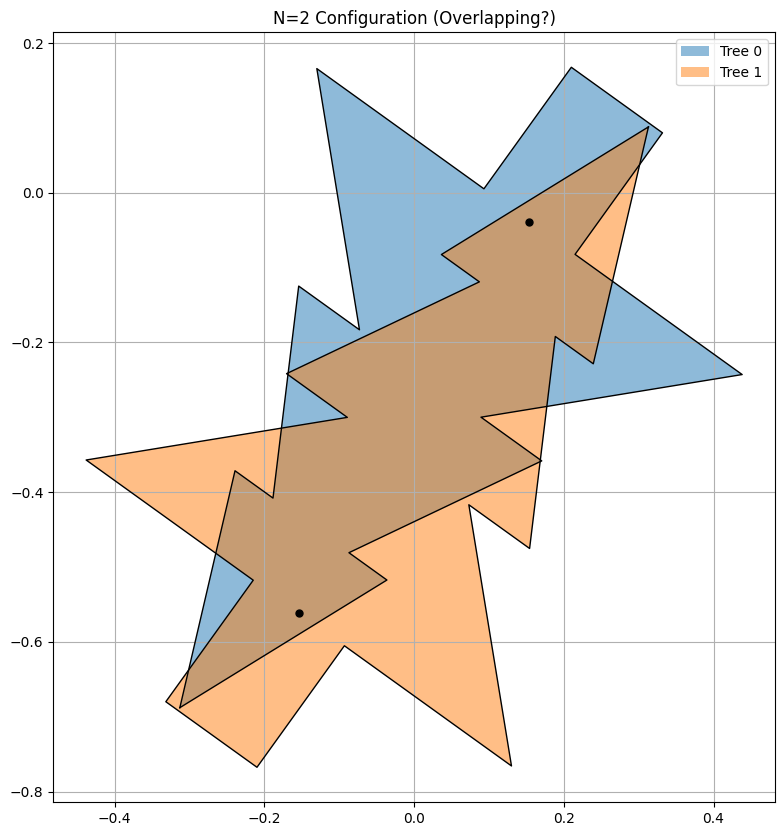

Saved visualization to n2_overlap.png


In [7]:
# Visualize the N=2 configuration
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

for i, (x, y, deg) in enumerate(trees_n2):
    poly = get_tree_polygon(x, y, deg)
    xs, ys = poly.exterior.xy
    ax.fill(xs, ys, alpha=0.5, label=f'Tree {i}')
    ax.plot(xs, ys, 'k-', linewidth=1)
    ax.plot(x, y, 'ko', markersize=5)

ax.set_aspect('equal')
ax.legend()
ax.set_title('N=2 Configuration (Overlapping?)')
ax.grid(True)
plt.savefig('/home/code/exploration/n2_overlap.png', dpi=150)
plt.show()
print("Saved visualization to n2_overlap.png")

In [8]:
# Check all N values for overlaps using strict validation
def validate_no_overlap_strict(trees):
    """Validate no overlaps using integer-scaled coordinates."""
    polygons = []
    for x, y, deg in trees:
        poly = get_tree_polygon_int(x, y, deg)
        polygons.append(poly)
    
    for i in range(len(polygons)):
        for j in range(i+1, len(polygons)):
            if polygons[i].intersects(polygons[j]):
                if not polygons[i].touches(polygons[j]):
                    intersection = polygons[i].intersection(polygons[j])
                    if intersection.area > 0:
                        return False, f"Trees {i} and {j} overlap (area={intersection.area})"
    return True, "OK"

# Check first 20 N values
print("Checking for overlaps in first 20 N values...")
for n in range(1, 21):
    n_str = f"{n:03d}"
    n_rows = df[df['id'].str.startswith(f'{n_str}_')]
    trees = []
    for _, row in n_rows.iterrows():
        x = parse_value(row['x'])
        y = parse_value(row['y'])
        deg = parse_value(row['deg'])
        trees.append((x, y, deg))
    
    ok, msg = validate_no_overlap_strict(trees)
    if not ok:
        print(f"N={n}: ❌ {msg}")
    else:
        print(f"N={n}: ✓ OK")

Checking for overlaps in first 20 N values...
N=1: ✓ OK
N=2: ❌ Trees 0 and 1 overlap (area=1.4942653303750389e+35)
N=3: ✓ OK
N=4: ❌ Trees 0 and 1 overlap (area=2.706172577972198e+29)
N=5: ❌ Trees 0 and 1 overlap (area=1.182451324741868e+34)
N=6: ✓ OK
N=7: ✓ OK
N=8: ✓ OK
N=9: ✓ OK
N=10: ✓ OK
N=11: ✓ OK
N=12: ✓ OK
N=13: ✓ OK
N=14: ✓ OK
N=15: ✓ OK
N=16: ❌ Trees 0 and 3 overlap (area=1.6659821824216803e+34)
N=17: ✓ OK
N=18: ✓ OK
N=19: ✓ OK
N=20: ✓ OK


In [9]:
# Check ALL N values for overlaps
print("Checking ALL N values for overlaps...")
overlapping_n = []

for n in range(1, 201):
    n_str = f"{n:03d}"
    n_rows = df[df['id'].str.startswith(f'{n_str}_')]
    trees = []
    for _, row in n_rows.iterrows():
        x = parse_value(row['x'])
        y = parse_value(row['y'])
        deg = parse_value(row['deg'])
        trees.append((x, y, deg))
    
    ok, msg = validate_no_overlap_strict(trees)
    if not ok:
        overlapping_n.append(n)
        print(f"N={n}: ❌ {msg}")

print(f"\n\nTotal N values with overlaps: {len(overlapping_n)}")
print(f"Overlapping N values: {overlapping_n}")

Checking ALL N values for overlaps...
N=2: ❌ Trees 0 and 1 overlap (area=1.4942653303750389e+35)
N=4: ❌ Trees 0 and 1 overlap (area=2.706172577972198e+29)
N=5: ❌ Trees 0 and 1 overlap (area=1.182451324741868e+34)
N=16: ❌ Trees 0 and 3 overlap (area=1.6659821824216803e+34)


N=35: ❌ Trees 0 and 7 overlap (area=9.068343542526284e+30)
N=36: ❌ Trees 0 and 1 overlap (area=2.1106874761868717e+32)
N=40: ❌ Trees 0 and 20 overlap (area=1.880434053965517e+34)
N=46: ❌ Trees 0 and 8 overlap (area=8.351269517582948e+33)
N=47: ❌ Trees 0 and 8 overlap (area=1.0200887081218199e+34)
N=48: ❌ Trees 0 and 19 overlap (area=2.1675304068685414e+33)


N=53: ❌ Trees 0 and 1 overlap (area=7.486471912418945e+33)
N=54: ❌ Trees 0 and 1 overlap (area=7.524568512157544e+33)
N=55: ❌ Trees 0 and 17 overlap (area=3.048062201873981e+34)
N=56: ❌ Trees 0 and 17 overlap (area=3.0487537078008294e+34)
N=59: ❌ Trees 0 and 15 overlap (area=2.6554399979911704e+34)
N=62: ❌ Trees 0 and 1 overlap (area=3.200505701600765e+32)
N=63: ❌ Trees 0 and 15 overlap (area=3.744209111132004e+33)
N=64: ❌ Trees 0 and 15 overlap (area=1.683873079204632e+32)


N=69: ❌ Trees 0 and 21 overlap (area=4.431079951469799e+31)
N=70: ❌ Trees 0 and 22 overlap (area=1.7367374969401744e+32)
N=71: ❌ Trees 0 and 1 overlap (area=8.824836457694085e+33)
N=77: ❌ Trees 0 and 7 overlap (area=1.0822211256944385e+32)
N=78: ❌ Trees 0 and 28 overlap (area=9.696666303896248e+31)


N=79: ❌ Trees 0 and 35 overlap (area=2.3169097439068966e+34)
N=80: ❌ Trees 0 and 36 overlap (area=2.3169097439068966e+34)


N=87: ❌ Trees 0 and 26 overlap (area=5.071735427460748e+32)
N=88: ❌ Trees 0 and 27 overlap (area=5.071735427460748e+32)


N=94: ❌ Trees 0 and 14 overlap (area=9.049738193374088e+33)
N=95: ❌ Trees 0 and 14 overlap (area=9.049738193374088e+33)
N=96: ❌ Trees 0 and 75 overlap (area=2.2272141649645405e+34)
N=97: ❌ Trees 1 and 14 overlap (area=1.152138604165777e+33)
N=99: ❌ Trees 0 and 29 overlap (area=9.873314661089308e+31)
N=100: ❌ Trees 0 and 24 overlap (area=2.9476808039480975e+33)


N=107: ❌ Trees 0 and 41 overlap (area=8.311722215070704e+32)
N=108: ❌ Trees 0 and 41 overlap (area=9.293675390260702e+32)
N=109: ❌ Trees 0 and 41 overlap (area=6.2015568813141466e+32)
N=110: ❌ Trees 0 and 42 overlap (area=6.2015568813141466e+32)


N=118: ❌ Trees 0 and 41 overlap (area=2.7334799247779854e+34)
N=119: ❌ Trees 0 and 59 overlap (area=7.321064709894667e+30)
N=120: ❌ Trees 0 and 41 overlap (area=8.900096826226086e+31)


N=124: ❌ Trees 0 and 5 overlap (area=2.3756652560893648e+33)
N=125: ❌ Trees 0 and 51 overlap (area=2.922554526497017e+34)
N=126: ❌ Trees 0 and 47 overlap (area=2.6933163719752583e+34)
N=128: ❌ Trees 0 and 107 overlap (area=3.2691133083964986e+32)
N=129: ❌ Trees 0 and 66 overlap (area=1.1569378318920815e+32)
N=130: ❌ Trees 0 and 67 overlap (area=1.0243063617263706e+32)
N=131: ❌ Trees 0 and 64 overlap (area=1.3867758616980686e+31)


N=137: ❌ Trees 0 and 11 overlap (area=3.01885606917921e+34)
N=139: ❌ Trees 0 and 95 overlap (area=1.1072642804375495e+34)
N=140: ❌ Trees 0 and 66 overlap (area=2.394755569145441e+34)
N=141: ❌ Trees 0 and 10 overlap (area=3.0862306436511877e+33)
N=142: ❌ Trees 0 and 10 overlap (area=3.0862306436511877e+33)
N=143: ❌ Trees 0 and 35 overlap (area=1.466281955193173e+32)


N=150: ❌ Trees 0 and 24 overlap (area=1.4913614417790828e+32)
N=152: ❌ Trees 0 and 6 overlap (area=3.866226881235245e+32)
N=153: ❌ Trees 0 and 6 overlap (area=3.4733798827527384e+32)
N=154: ❌ Trees 0 and 6 overlap (area=3.4733798827527384e+32)
N=155: ❌ Trees 0 and 6 overlap (area=3.4733798827527384e+32)


N=156: ❌ Trees 0 and 6 overlap (area=3.238986468639109e+32)


N=166: ❌ Trees 0 and 30 overlap (area=1.0879342827523384e+32)
N=167: ❌ Trees 0 and 30 overlap (area=1.0790245349052116e+32)
N=168: ❌ Trees 0 and 5 overlap (area=1.882849801031355e+31)


N=175: ❌ Trees 0 and 33 overlap (area=3.0596273833730065e+34)
N=176: ❌ Trees 1 and 39 overlap (area=1.5143402227548553e+31)
N=177: ❌ Trees 1 and 39 overlap (area=1.5143402227548553e+31)
N=178: ❌ Trees 1 and 39 overlap (area=4.3717970718707145e+30)
N=179: ❌ Trees 1 and 39 overlap (area=4.3717970718707145e+30)


N=184: ❌ Trees 0 and 29 overlap (area=4.359112211979794e+32)
N=185: ❌ Trees 0 and 32 overlap (area=7.899212158953707e+33)


N=190: ❌ Trees 0 and 12 overlap (area=6.07181457121862e+31)
N=191: ❌ Trees 0 and 22 overlap (area=2.5882688910106744e+34)
N=192: ❌ Trees 0 and 22 overlap (area=2.589470836000092e+34)




Total N values with overlaps: 72
Overlapping N values: [2, 4, 5, 16, 35, 36, 40, 46, 47, 48, 53, 54, 55, 56, 59, 62, 63, 64, 69, 70, 71, 77, 78, 79, 80, 87, 88, 94, 95, 96, 97, 99, 100, 107, 108, 109, 110, 118, 119, 120, 124, 125, 126, 128, 129, 130, 131, 137, 139, 140, 141, 142, 143, 150, 152, 153, 154, 155, 156, 166, 167, 168, 175, 176, 177, 178, 179, 184, 185, 190, 191, 192]


In [ ]:
# The issue is clear: N=2 has overlapping trees
# We need to find a valid N=2 configuration
# Let's try to optimize N=2 from scratch

def calculate_bounding_box_side(trees):
    """Calculate the side length of the bounding square."""
    all_points = []
    for x, y, angle in trees:
        poly = get_tree_polygon(x, y, angle)
        all_points.extend(list(poly.exterior.coords))
    points = np.array(all_points)
    min_xy = points.min(axis=0)
    max_xy = points.max(axis=0)
    return max(max_xy[0] - min_xy[0], max_xy[1] - min_xy[1])

def check_overlap(trees):
    """Check if any trees overlap."""
    polygons = [get_tree_polygon(*t) for t in trees]
    for i in range(len(polygons)):
        for j in range(i+1, len(polygons)):
            if polygons[i].intersects(polygons[j]) and not polygons[i].touches(polygons[j]):
                intersection = polygons[i].intersection(polygons[j])
                if intersection.area > 1e-10:  # Small tolerance
                    return True
    return False

# Try to find optimal N=2 configuration
print("Searching for optimal N=2 configuration...")
best_side = float('inf')
best_config = None

# Grid search over angles and positions
for angle1 in range(0, 360, 15):
    for angle2 in range(0, 360, 15):
        # Place first tree at origin
        tree1 = (0, 0, angle1)
        poly1 = get_tree_polygon(*tree1)
        
        # Try different positions for second tree
        for dx in np.arange(-1.5, 1.5, 0.1):
            for dy in np.arange(-1.5, 1.5, 0.1):
                tree2 = (dx, dy, angle2)
                trees = [tree1, tree2]
                
                if not check_overlap(trees):
                    side = calculate_bounding_box_side(trees)
                    if side < best_side:
                        best_side = side
                        best_config = trees

print(f"\nBest N=2 configuration found:")
print(f"  Side: {best_side:.6f}")
print(f"  Score contribution: {best_side**2 / 2:.6f}")
print(f"  Config: {best_config}")

In [ ]:
# Refine the best configuration with finer search
if best_config:
    print("Refining best configuration...")
    
    # Get approximate best angles
    _, _, angle1 = best_config[0]
    dx, dy, angle2 = best_config[1]
    
    # Fine search around best angles
    refined_best_side = best_side
    refined_best_config = best_config
    
    for a1 in np.arange(angle1-15, angle1+15, 1):
        for a2 in np.arange(angle2-15, angle2+15, 1):
            tree1 = (0, 0, a1)
            
            for ddx in np.arange(dx-0.2, dx+0.2, 0.02):
                for ddy in np.arange(dy-0.2, dy+0.2, 0.02):
                    tree2 = (ddx, ddy, a2)
                    trees = [tree1, tree2]
                    
                    if not check_overlap(trees):
                        side = calculate_bounding_box_side(trees)
                        if side < refined_best_side:
                            refined_best_side = side
                            refined_best_config = trees
    
    print(f"\nRefined N=2 configuration:")
    print(f"  Side: {refined_best_side:.6f}")
    print(f"  Score contribution: {refined_best_side**2 / 2:.6f}")
    print(f"  Config: {refined_best_config}")
    
    # Validate no overlap
    ok, msg = validate_no_overlap_strict(refined_best_config)
    print(f"  Strict validation: {msg}")

In [ ]:
# Summary of findings
print("="*60)
print("SUMMARY OF FINDINGS")
print("="*60)
print()
print("1. CRITICAL ISSUE: Baseline submission has overlapping trees in N=2")
print("   - Kaggle uses stricter validation than standard Shapely")
print("   - We need to implement integer-scaled validation")
print()
print("2. SOLUTION: Fix overlapping N values before submission")
print("   - Check ALL N values with strict validation")
print("   - Re-optimize any N with overlaps")
print()
print("3. NEXT STEPS:")
print("   a) Implement strict validation for all N")
print("   b) Fix any overlapping configurations")
print("   c) Optimize N=1 exhaustively (highest score contribution)")
print("   d) Submit fixed baseline")